# Radial Profile Example

Isaac Cheng - October 2021

Some basic examples to show how to use the radial profile package. Steps to get started:

0. Requires: `astropy`, `numpy`, `matplotlib`, `photutils`, `radio_beam`
1. Download `radial_profile.py` and `radial_profile_utils.py` (both necessary) and put
   them in the same folder
2. Download this notebook and, if you don't want to fuss around with import statements,
   put this in the same folder as the two files above
3. You will need to replace my imported data with your data (e.g., from a FITS file). I
   cannot make my data publicly available

Finally, feature requests and bug reports are welcome! Service fees and shipping +
handling charges may apply.


In [1]:
# You do not need the following line. I only need it since I'm using VS Code with sshfs
%cd "/arc/home/IsaacCheng/coop_f2021/packages"

from radial_profile import RadialProfile

/arc/home/IsaacCheng/coop_f2021/packages


## Import data


In [2]:
import astropy.coordinates as coord
from astropy.io import fits
import numpy as np

co_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
co_unc_path = "/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
data_co, header_co = fits.getdata(co_path, header=True)
unc_co = fits.getdata(co_unc_path)
centre_co = coord.SkyCoord(
    ra="12h25m22.16s", dec="+10d01m00.12s", frame=header_co["RADESYS"].lower()
)
inclination_co = 61  # degrees
pa_co = 158  # position angle, degrees
data_co[data_co <= 0] = np.nan  # remove background

## Generate radial profile


In [3]:
# 
# Initialize RadialProfile object
# 
NGC4380_no_rp = RadialProfile(data_co, centre_co, inclination_co, pa_co, noise=unc_co)
# 
# Generate radial profile
# 
NGC4380_rp = NGC4380_no_rp.calc_radial_profile(
    n_annuli=5,
    # snr_cutoff=0,  # requires noise to be set (when initializing RadialProfile object)
    # max_snr_annuli=5,
    header=header_co,
    include_bad=False,
    func="mean",
    debug_plot=False,
    is_radio=True,
    bootstrap_errs=True,  # estimates standard error on the mean
                          # Also see uncetainty section below
    n_bootstraps=100,
    bootstrap_seed=314,  # for reproducibility if anyone has the same data
                         # Does not affect global seed
)

Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364


## See all public methods and attributes of the object


In [4]:
print([attr for attr in dir(NGC4380_rp) if not attr.startswith("__")])
print("rp_options attribute:", NGC4380_rp.rp_options.keys())
print("Include bad:", NGC4380_rp.rp_options["include_bad"])

['a_ins', 'a_outs', 'annuli', 'avg_data', 'avg_data_err', 'avg_noise', 'avg_noise_err', 'b_ins', 'b_outs', 'calc_area', 'calc_radial_profile', 'center', 'copy', 'correct_for_i', 'data', 'i', 'noise', 'pa', 'radii', 'rp_options', 'std_data', 'std_noise']
rp_options attribute: dict_keys(['i_threshold', 'n_annuli', 'snr_cutoff', 'max_snr_annuli', 'min_width', 'min_width_ax', 'header', 'wcs', 'include_bad', 'func', 'method', 'is_radio', 'header_min_width_key', 'header_min_width_unit', 'bootstrap_errs', 'n_bootstraps', 'n_samples', 'bootstrap_seed'])
Include bad: False


## Calculate the uncertainty in integrated intensity

Use Eq. (8) of Brown et al. (2021). This applies to my example data above. May not apply
to yours


In [5]:
import radial_profile_utils as rpu
#
# Calculate the number of pixels included in each annulus
# 
NGC4380_data_area, NGC4380_noise_area = NGC4380_rp.calc_area()
# print(NGC4380_data_area, NGC4380_noise_area)  # these should be equal. Only need one
# 
# Apply Eq. (8) of Brown et al. (2021) to get the uncertainty in the intensity profile
# 
beam_major, beam_minor, _ = rpu.get_beam_size_px(header_co)
beam_area = np.pi * (beam_major / 2) * (beam_minor / 2)  # area of ellipse in pixel units
num_beams = NGC4380_data_area / beam_area
unc_avg_co = NGC4380_rp.std_data * np.sqrt(num_beams)  # Eq. (8) of Brown et al. (2021)
# ? I think there may be a typo in the version of the paper I have...
# ? unc_avg_co should be DIVIDED by sqrt(num_beams) since num_beams is effectively the
# ? "sample size"...
print("Num beams:\t\t\t\t", num_beams)
print("Standard deviation of data:\t\t", NGC4380_rp.std_data)
print("Brown et al. (2021) uncertainty:\t", NGC4380_rp.avg_data_err)

Num beams:				 [ 8.25066136 24.75198408 41.25330679 51.58228    14.08002904]
Standard deviation of data:		 [1.5643997  0.6557115  0.35568345 0.45986754 0.28767401]
Brown et al. (2021) uncertainty:	 [0.15091145 0.03254746 0.01779456 0.01625375 0.02189888]


## Calculate the standard error.

Notice how well it agrees with the estimate derived from bootstrapping (as expected)


In [6]:
# See https://en.wikipedia.org/wiki/Standard_error#Exact_Value.
# Assumes independent samples
standard_error = NGC4380_rp.std_data / np.sqrt(NGC4380_data_area)
print("Standard Errors:\t", standard_error)
print("Bootstrapping Errors:\t", NGC4380_rp.avg_data_err)

Standard Errors:	 [0.13656704 0.03304839 0.01388599 0.01605554 0.0192239 ]
Bootstrapping Errors:	 [0.15091145 0.03254746 0.01779456 0.01625375 0.02189888]


## Plot the radial profile

Note that the average radius of an ellipse or annulus is defined as the arithmetic mean of
the inner and outer circularized radii. See the `calc_radius()` function in
`radial_profile_utils.py` for more information.


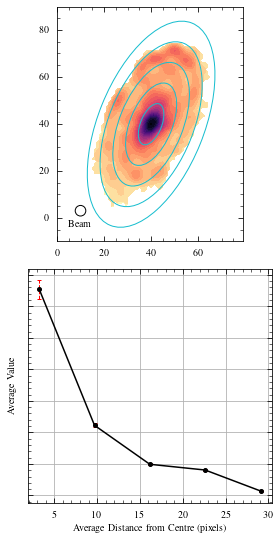

In [7]:
# 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.9))
ax1 = fig.add_subplot(2, 1, 1)
#
# Plot data
#
img1 = ax1.contourf(data_co, cmap="magma_r", levels=22)
# Add annuli
for annulus in NGC4380_rp.annuli[::-1]:  # plot annuli from outer to inner
    try:
        # EllipticalAnnulus attributes
        width = annulus.b_out
        height = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes
        width = annulus.b
        height = annulus.a
    ellipse = Ellipse(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        # PA is 0 deg at North & increases CCW by convention
        angle=(np.rad2deg(annulus.theta) - 90) % 360.0,
        ls="-",
        edgecolor="tab:cyan",
        fc="None",
        lw=1,
        zorder=2,
    )
    ax1.add_patch(ellipse)
# Add beam size
co_beam_major, co_beam_minor, co_beam_pa = rpu.get_beam_size_px(header_co)
xbeam, ybeam = 10, 3
ellipse = Ellipse(
    xy=(xbeam, ybeam),
    width=co_beam_minor,
    height=co_beam_major,
    angle=(co_beam_pa - 90) % 360.0,  # PA is 0 deg at North & increases CCW by convention
    ls="-",
    edgecolor="k",
    fc="None",
    lw=1,
    zorder=2,
)
ax1.add_patch(ellipse)
xtxt, ytxt = (xbeam - 5.5, ybeam - 7)
ax1.text(xtxt, ytxt, "Beam")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=NGC4380_rp.radii,
    y=NGC4380_rp.avg_data,
    # yerr=standard_error,  # standard error on the mean
    yerr=NGC4380_rp.avg_data_err,  # uncertainty in the mean from bootstrapping
    # yerr=unc_avg_co,  # uncertainty using Eq. (8) of Brown et al. (2021)
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
ax2.set_xlabel("Average Distance from Centre (pixels)")
ax2.set_ylabel("Average Value")
ax2.set_yticklabels([])  # hide exact values
#
fig.tight_layout()
plt.show()


## Correct for inclination

This is not necessary for my example data. Nonetheless, I will briefly show how this is
done


In [8]:
# N.B. Correcting for inclination only affects the data, noise, avg_data, and avg_noise
# attributes.
# Since we are multiplying everything by a constant, there is no effect on the standard
# deviation, standard error, etc.
NGC4380_rp_corrected = NGC4380_rp.correct_for_i(i_replacement=80)

In [9]:
# Hide exact values
rng = np.random.default_rng()
rand_val = rng.uniform(low=1, high=10)
# 
print("Uncorrected avg data:\t", NGC4380_rp.avg_data * rand_val)
print("Corrected avg data:\t", NGC4380_rp_corrected.avg_data * rand_val)
print("Uncorrected avg noise:\t", NGC4380_rp.avg_noise * rand_val)
print("Corrected avg noise:\t", NGC4380_rp_corrected.avg_noise * rand_val)

Uncorrected avg data:	 [37.08787365 15.85204531  9.77994973  8.88565148  5.62217952]
Corrected avg data:	 [17.98055794  7.68522407  4.74141372  4.30784932  2.72568672]
Uncorrected avg noise:	 [0.09876086 0.04636118 0.03213576 0.02785134 0.05039539]
Corrected avg noise:	 [0.04788022 0.02247634 0.01557972 0.0135026  0.02443217]
